In [1]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os


test set: https://forums.fast.ai/t/how-to-add-a-test-set/38956/7
text.data reference methods: https://docs.fast.ai/text.html

In [2]:
data = pd.read_csv("sample_prod_cat.csv")

In [3]:
df = pd.DataFrame({'label':data.labels, 'text':data.text})

In [4]:
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")
import nltk 

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

#remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [5]:

detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
    
df['text'] = detokenized_doc

In [6]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.3, random_state = 12)
df_trn.shape, df_val.shape

((695, 2), (299, 2))

In [7]:
#language model data - vectorization 
data_lm = TextLMDataBunch.from_df(train_df=df_trn, valid_df=df_val, path = "")

# Classifier model data - 
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)


In [8]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.5)


In [ ]:
learn.lr_find(start_lr=1e-5, end_lr=10000)
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.379017,2.634201,0.496763,00:16


In [10]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7)) #decrease learning rate by a factor of 10? why? 

epoch,train_loss,valid_loss,accuracy,time
0,2.435316,1.692110,0.705357,00:24
1,2.134841,1.631045,0.721875,00:26
2,1.956515,1.451104,0.754241,00:26
3,1.780841,1.257708,0.767411,00:32
4,1.643363,1.227711,0.776004,00:25
5,1.525132,1.184564,0.776339,00:25
6,1.422720,1.140225,0.783929,00:27
7,1.332157,1.137418,0.784710,00:26
8,1.263697,1.124148,0.786049,00:26
9,1.201425,1.127244,0.785826,00:26


In [11]:
learn.save_encoder('ft_enc_best')

In [12]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc_best')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


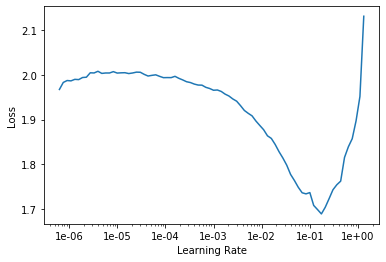

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn1 = learn
learn1.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn1.save('clas_first') 


epoch,train_loss,valid_loss,accuracy,time
0,1.627122,1.549975,0.468227,00:09


In [15]:
learn1.freeze_to(-2)
learn1.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))  #decrease learning rate by a factor of 10? 
learn1.save('clas_first_1')

epoch,train_loss,valid_loss,accuracy,time
0,1.318250,1.130752,0.605351,00:13


In [16]:
learn1.freeze_to(-3)
learn1.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))  #decrease learning rate to middle of spike down? (factor of 10?)
learn1.save('clas_first_2')


epoch,train_loss,valid_loss,accuracy,time
0,1.048600,0.885444,0.725753,00:23


In [17]:
learn1.unfreeze()
learn1.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))  #decrease lr slightly further

epoch,train_loss,valid_loss,accuracy,time
0,0.915367,0.764636,0.745819,00:32


(Category cookies & crackers,
 tensor(2),
 tensor([0.1730, 0.0585, 0.3462, 0.1892, 0.0931, 0.0715, 0.0685]))

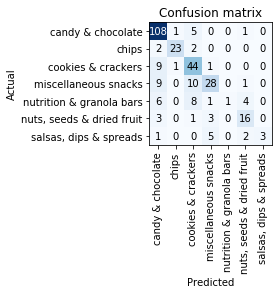

In [45]:
learn1.fit_one_cycle(1, 5e-3, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.730749,0.689458,0.799331,00:29


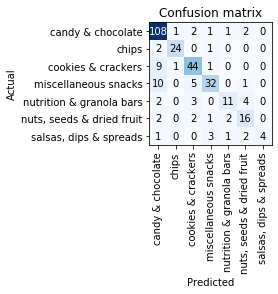

In [46]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [47]:
learn1.fit_one_cycle(1, 5e-3, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.554089,0.664715,0.819398,00:34


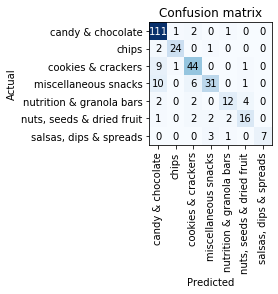

In [48]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

In [76]:
learn1.save("good_pantry_1_model")

In [70]:
learn1.predict("Planters Salted Caramel Nuts - 5oz")

(Category nuts, seeds & dried fruit,
 tensor(5),
 tensor([0.0249, 0.0295, 0.0059, 0.0838, 0.0460, 0.7708, 0.0392]))

In [71]:
learn1.predict("Planters NUT-rition Essential Nutrients Deluxe Nut Mix - 5.5oz")

(Category nutrition & granola bars,
 tensor(4),
 tensor([0.0516, 0.0462, 0.2148, 0.1605, 0.3526, 0.0466, 0.1277]))

In [72]:
learn1.predict("Gummi Worms - 7oz - Market Pantry™")

(Category candy & chocolate,
 tensor(0),
 tensor([0.3415, 0.0780, 0.2661, 0.2259, 0.0354, 0.0294, 0.0237]))

In [73]:
learn1.predict("HERSHEY'S Miniatures Party Bag Assorted Chocolate Candy Bars - 40oz")

(Category candy & chocolate,
 tensor(0),
 tensor([9.8205e-01, 5.8876e-04, 2.3955e-03, 7.8942e-04, 1.0749e-02, 9.5450e-04,
         2.4686e-03]))

In [74]:
learn1.predict("Dum Dums Original Assorted Flavors Lollipops - 1000ct")

(Category candy & chocolate,
 tensor(0),
 tensor([0.6330, 0.0551, 0.0650, 0.1879, 0.0197, 0.0163, 0.0230]))

In [77]:
learn1.predict("JOLLY RANCHER Original Flavors Hard Candies - 3.75lbs")

(Category miscellaneous snacks,
 tensor(3),
 tensor([0.1500, 0.0647, 0.0755, 0.3455, 0.1416, 0.0099, 0.2128]))

In [78]:
learn1.predict("Almonds, Peanuts & Sea Salt with Cocoa Drizzle Nut Bars - 12ct - Simply Balanced™")

(Category nutrition & granola bars,
 tensor(4),
 tensor([0.1700, 0.0299, 0.0241, 0.0433, 0.4931, 0.1166, 0.1229]))

In [79]:
learn1.predict("Kashi Dark Mocha Almond Chewy Granola Bars - 6ct")

(Category nutrition & granola bars,
 tensor(4),
 tensor([0.1884, 0.0084, 0.0054, 0.0092, 0.6995, 0.0320, 0.0573]))

In [81]:
learn1.predict("Organic Roasted Restaurant Style Salsa 24oz - Simply Balanced™")

(Category nuts, seeds & dried fruit,
 tensor(5),
 tensor([4.5358e-04, 3.0015e-02, 1.2658e-03, 1.0326e-02, 1.2712e-02, 6.1387e-01,
         3.3136e-01]))

In [82]:
learn1.predict("Pace® Mild Chunky Salsa 64 oz")

(Category salsas, dips & spreads,
 tensor(6),
 tensor([6.3187e-08, 9.1097e-04, 5.9632e-05, 3.7995e-06, 6.5793e-03, 2.8166e-04,
         9.9216e-01]))

In [83]:
learn1.predict("Pepperidge Farm® Pirouette® Crème Filled Wafers Chocolate Hazelnut Cookies, 13.5oz Tin")

(Category candy & chocolate,
 tensor(0),
 tensor([0.4509, 0.0440, 0.4333, 0.0346, 0.0278, 0.0044, 0.0049]))

In [84]:
learn1.predict("Milkmakers Oatmeal Chocolate Chip Cookies - 10ct")

(Category cookies & crackers,
 tensor(2),
 tensor([0.1335, 0.0189, 0.8127, 0.0090, 0.0212, 0.0015, 0.0032]))

In [85]:
learn1.predict("Skinny Pop Popcorn 100 Calorie Bags - 24ct")

(Category miscellaneous snacks,
 tensor(3),
 tensor([0.0047, 0.0168, 0.0363, 0.8262, 0.0350, 0.0163, 0.0647]))